# Analyse Weights and Biases Runs

#### Import Libraries

In [1]:
# Import Libraries & Load Data
# !pip install wandb pandas matplotlib seaborn
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Set display options for wide DataFrames
pd.set_option('display.max_columns', 50)

#### Define project names

In [2]:
# Define W&B Project names
projects = [
    "tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug_rev",
    "tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug",
    "tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout",
    "tkshfj-bsc-computer-science-university-of-london/baseline_shallow_cnn"
]

#### Connect to W&B and Download Runs

In [3]:
# Initialize W&B API
api = wandb.Api()

all_runs_hyperparams = []

for project in projects:
    print(f"Fetching runs from: {project}")
    runs = api.runs(project)

    for run in runs:
        if run.state == "finished":
            config = {k: v for k, v in run.config.items() if not k.startswith("_")}
            config['run_id'] = run.id
            config['run_name'] = run.name
            all_runs_hyperparams.append(config)

# Convert to DataFrame
df_all_hyperparams = pd.DataFrame(all_runs_hyperparams)

# Show the result
df_all_hyperparams.head()


Fetching runs from: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug_rev
Fetching runs from: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug
Fetching runs from: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout
Fetching runs from: tkshfj-bsc-computer-science-university-of-london/baseline_shallow_cnn


,zoom,epochs,dropout,filters,rotation,optimizer,batch_size,kernel_size,translation,learning_rate,run_id,run_name,architecture
0,0.118281,20,0.457431,32.0,0.185733,Adam,12,3.0,0.028774,0.000535,robn7eui,pleasant-sweep-1,NaN
1,0.064598,20,0.336429,16.0,0.169841,Adam,12,5.0,0.198497,0.000925,3g59hei1,fresh-sweep-2,NaN
2,0.073080,20,0.302445,16.0,0.168715,Adam,8,5.0,0.029685,0.000899,qecspgb9,vague-sweep-3,NaN
3,0.105956,20,0.453570,16.0,0.005078,Adam,16,3.0,0.179405,0.000526,a55xgzua,peach-sweep-4,NaN
4,0.116883,20,0.352475,16.0,0.093815,Adam,12,3.0,0.098259,0.000551,0tiuh0xt,woven-sweep-5,NaN


In [4]:
df_all_hyperparams.to_csv("all_runs_hyperparams.csv", index=True)

#### Fetch runs from projects

In [5]:
def fetch_runs(project):
    runs = api.runs(project)
    records = []
    for run in runs:
        if run.state == "finished":
            rec = dict(run.summary)
            rec.update(dict(run.config))
            rec["run_id"] = run.id
            rec["run_name"] = run.name
            records.append(rec)
    return pd.DataFrame(records)

#### Try to get predictions and labels from run summary or artifacts

In [6]:
def try_get_preds_labels(run):
    # As summary arrays
    preds = run.summary.get('preds') or run.summary.get('y_pred') or run.summary.get('predictions')
    labels = run.summary.get('labels') or run.summary.get('y_true') or run.summary.get('ground_truth')
    if preds is not None and labels is not None:
        # Convert to np arrays if necessary
        preds = np.array(preds)
        labels = np.array(labels)
        # If predictions are probabilities, convert to binary
        if preds.ndim > 1 and preds.shape[-1] == 2:  # [N, 2]
            preds = np.argmax(preds, axis=1)
        elif preds.ndim == 1 and (preds.max() > 1 or preds.min() < 0):
            preds = (preds > 0.5).astype(int)
        return preds, labels

    # Look for wandb Table artifact
    for artifact in run.logged_artifacts():
        if "confusion" in artifact.name or "eval" in artifact.name or "pred" in artifact.name:
            table = artifact.get("table")
            if table:
                df = table.dataframe()
                pred_col = [c for c in df.columns if "pred" in c][0]
                label_col = [c for c in df.columns if "label" in c][0]
                preds = df[pred_col].values
                labels = df[label_col].values
                return preds, labels
    # Not found
    return None, None

#### Get best run by validation AUC and plot loss and AUC curves

Processing project: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug_rev
Best run: colorful-sweep-6, val_auc=0.733


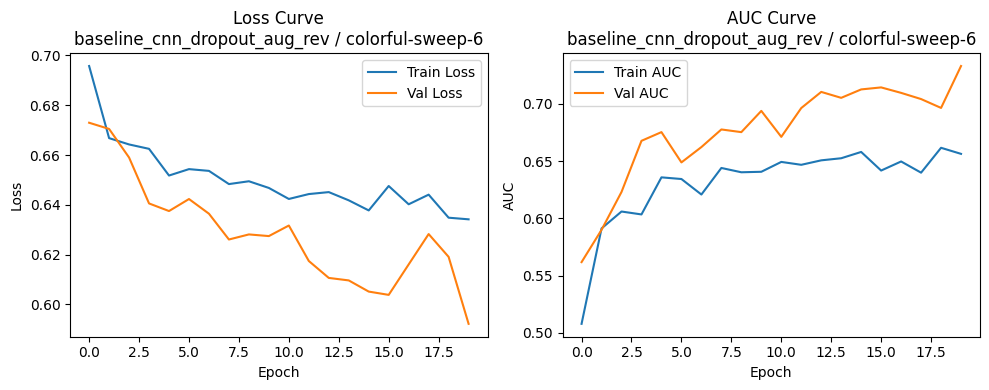

Processing project: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug
Best run: rural-sweep-1, val_auc=0.730


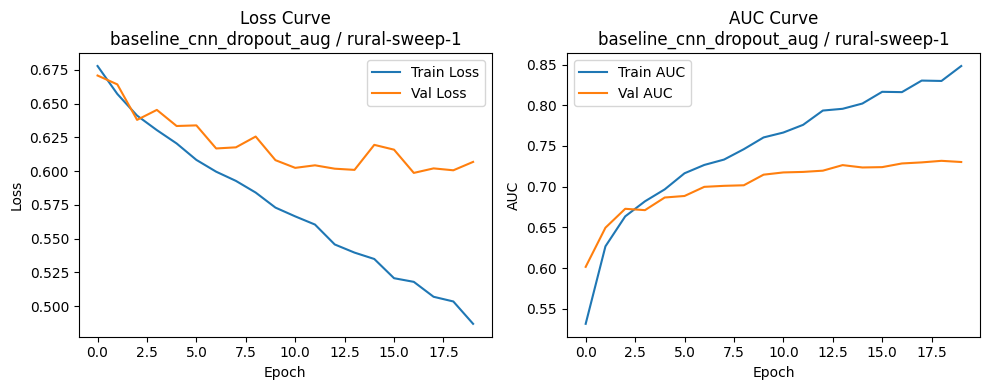

Processing project: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout
Best run: deep-sweep-3, val_auc=0.749


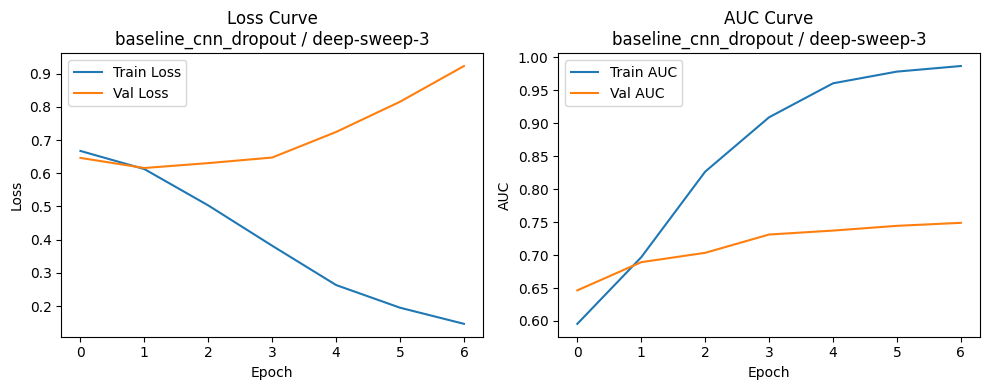

Processing project: tkshfj-bsc-computer-science-university-of-london/baseline_shallow_cnn
Best run: classic-surf-1, val_auc=0.792


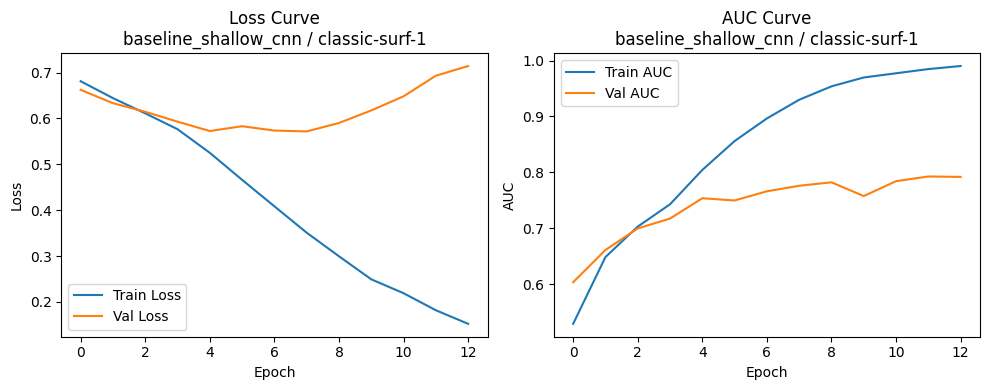

Summary of best runs per project:


,Project,Run Name,val_accuracy,val_auc,val_loss
0,baseline_cnn_dropout_aug_rev,colorful-sweep-6,0.665779,0.733171,0.592204
1,baseline_cnn_dropout_aug,rural-sweep-1,0.683089,0.730330,0.606858
2,baseline_cnn_dropout,deep-sweep-3,0.671105,0.748847,0.922707
3,baseline_shallow_cnn,classic-surf-1,0.728362,0.791855,0.714357


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

summary_table = []

for project in projects:
    print(f"Processing project: {project}")
    df = fetch_runs(project)
    
    if df.empty or 'epoch/val_auc' not in df.columns:
        print(f"No suitable runs found in {project}")
        continue

    # Get best run by validation AUC
    best_run_row = df.sort_values('epoch/val_auc', ascending=False).iloc[0]
    print(f"Best run: {best_run_row['run_name']}, val_auc={best_run_row['epoch/val_auc']:.3f}")

    # Append to summary
    summary_table.append({
        'Project': project.split('/')[-1],
        'Run Name': best_run_row['run_name'],
        'val_accuracy': best_run_row['epoch/val_accuracy'],
        'val_auc': best_run_row.get('epoch/val_auc', None),
        'val_loss': best_run_row.get('epoch/val_loss', None)
    })

    # Plot curves for best run
    run = api.run(f"{project}/{best_run_row['run_id']}")
    history = run.history(keys=[
        "epoch/epoch", "epoch/loss", "epoch/val_loss", "epoch/auc", "epoch/val_auc"
    ])

    epochs = history["epoch/epoch"]

    # Side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Loss Curve
    axes[0].plot(epochs, history["epoch/loss"], label="Train Loss")
    axes[0].plot(epochs, history["epoch/val_loss"], label="Val Loss")
    axes[0].set_title(f"Loss Curve\n{project.split('/')[-1]} / {best_run_row['run_name']}")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # AUC Curve
    axes[1].plot(epochs, history["epoch/auc"], label="Train AUC")
    axes[1].plot(epochs, history["epoch/val_auc"], label="Val AUC")
    axes[1].set_title(f"AUC Curve\n{project.split('/')[-1]} / {best_run_row['run_name']}")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("AUC")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Show summary table
summary_df = pd.DataFrame(summary_table)
print("Summary of best runs per project:")
display(summary_df)
